<a href="https://colab.research.google.com/github/KeyMoney22/Plant_disease_classification-/blob/VGG19/copy_of_tomato_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Relevant Libraries

In [ ]:
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras import models, layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# # Mount Google Drive
# drive.mount('/content/drive')

# # Navigate to your folder
folder_path = '/content/drive/MyDrive/PlantVillage'




## 2. Loading our dataset.

In [ ]:
data= tf.keras.utils.image_dataset_from_directory(folder_path, labels='inferred', label_mode='categorical',
                                            class_names=None, color_mode='rgb', batch_size=32,
                                            image_size=(256, 256), shuffle=True, seed=None,
                                            validation_split=None, subset=None, interpolation='bilinear',
                                            follow_links=False, crop_to_aspect_ratio=False)

Found 16031 files belonging to 10 classes.


In [ ]:
# Checking and printing the length of our data
print('The length of our data is', len(data))

# Checking the shape of our images and labels
for image_batch, label_batch in data:
  print('Image Batch Shape', image_batch.shape)
  print('Label Batch Shape', label_batch.shape)
  break
  #3 = rgb
  #32 = batch size
  # 256, 256= height , weight

The length of our data is 501
Image Batch Shape (32, 256, 256, 3)
Label Batch Shape (32, 10)


### Visualizing some of our images

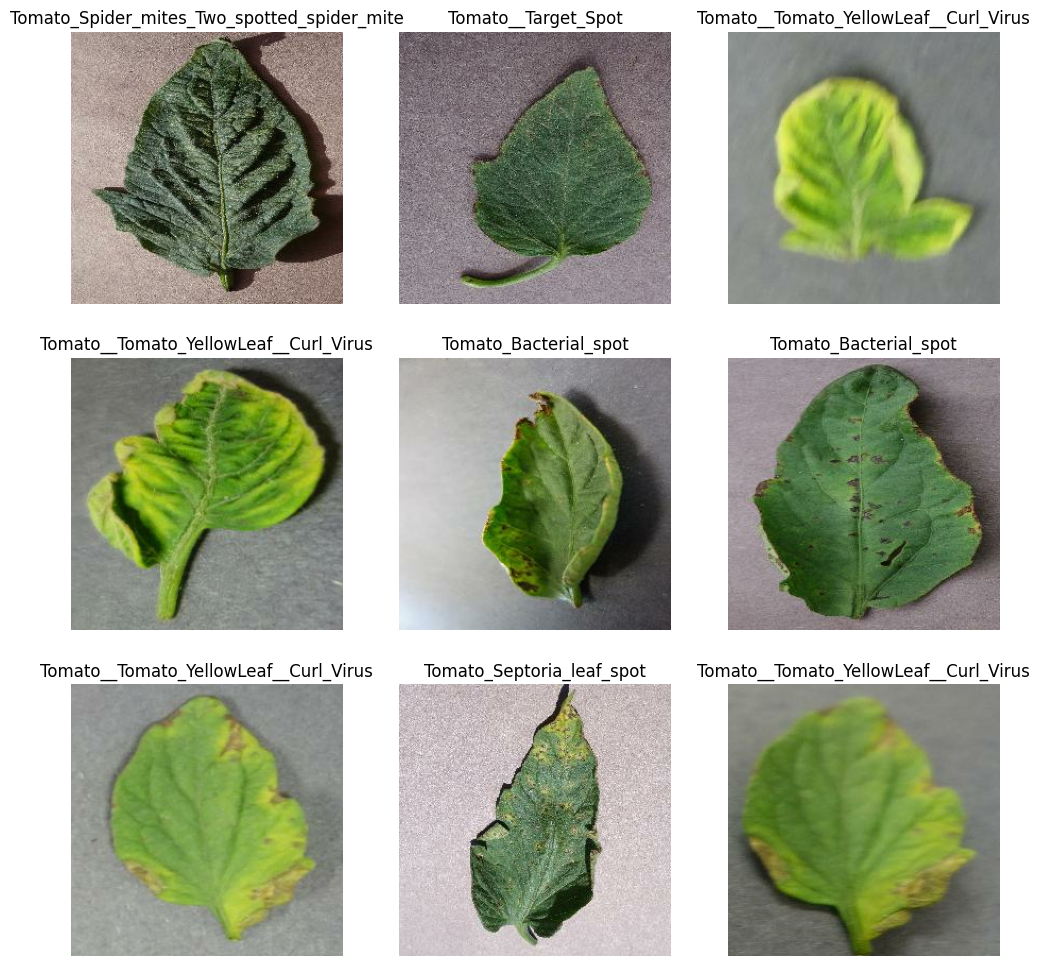

In [ ]:
def preview_data(dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")#hide the numbers
    plt.show()

class_names = data.class_names
preview_data(data, class_names)


## 3. Data Cleaning and Preperation

**Cleaning the class names**

In [ ]:
#Checking our class names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:

# Cleaning and printing the formarted class names
def clean_class_name(name):
    name = name.replace('__', '_')
    name = name.replace('__', '_')
    if name == 'Tomato_Spider_mites_Two_spotted_spider_mite':
        name = 'Tomato_Spider_mites'
    elif name == 'Tomato_Tomato_YellowLeaf_Curl_Virus':
        name = 'Tomato_Yellow_Leaf_Curl_Virus'
    elif name == 'Tomato_Tomato_mosaic_virus':
        name = 'Tomato_Mosaic_Virus'
    name = name.lower()
    return name

class_names = [clean_class_name(name) for name in class_names]
class_names

['tomato_bacterial_spot',
 'tomato_early_blight',
 'tomato_late_blight',
 'tomato_leaf_mold',
 'tomato_septoria_leaf_spot',
 'tomato_spider_mites',
 'tomato_target_spot',
 'tomato_yellow_leaf_curl_virus',
 'tomato_mosaic_virus',
 'tomato_healthy']

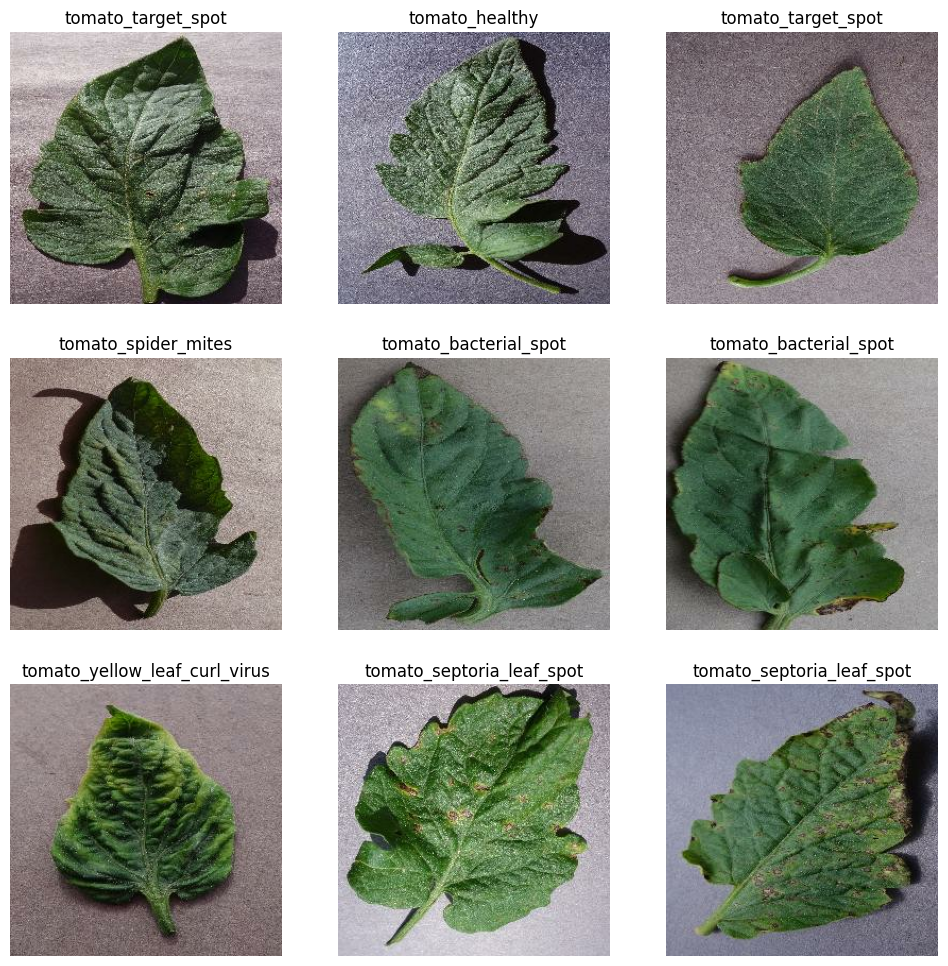

In [ ]:
preview_data(data, class_names)

**Checking for Corrupt images**

In [ ]:
def check_corrupt_images(folder_path):
    corrupt_images = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                corrupt_images.append(os.path.join(root, file))
    return corrupt_images

corrupt_images = check_corrupt_images(folder_path)
print(f"Found {len(corrupt_images)} corrupt images.")

Found 0 corrupt images.


In [ ]:
# Removing Corrupt images
for img_path in corrupt_images:
    try:
      os.remove(img_path)
      print(f"Corrupt image removed:{img_path}")
    except OSError:
      pass

**Class Distribution**

In [ ]:
# # A function to check class distribution
def check_class_distribution(dataset):
    class_counts = {}
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[tf.argmax(label)]
            if class_name in class_counts:
                class_counts[class_name] += 1
            else:
                class_counts[class_name] = 1
    return class_counts

# Checking class distribution
class_distribution = check_class_distribution(data)

# Sorting the dictionary by values (class counts) in ascending order
sorted_class_distribution = dict(sorted(class_distribution.items(), key=lambda item: item[1]))

print("Sorted class distribution (ascending):", sorted_class_distribution)


Sorted class distribution (ascending): {'tomato_mosaic_virus': 373, 'tomato_leaf_mold': 952, 'tomato_early_blight': 1000, 'tomato_target_spot': 1404, 'tomato_healthy': 1601, 'tomato_spider_mites': 1676, 'tomato_septoria_leaf_spot': 1771, 'tomato_late_blight': 1919, 'tomato_bacterial_spot': 2127, 'tomato_yellow_leaf_curl_virus': 3208}


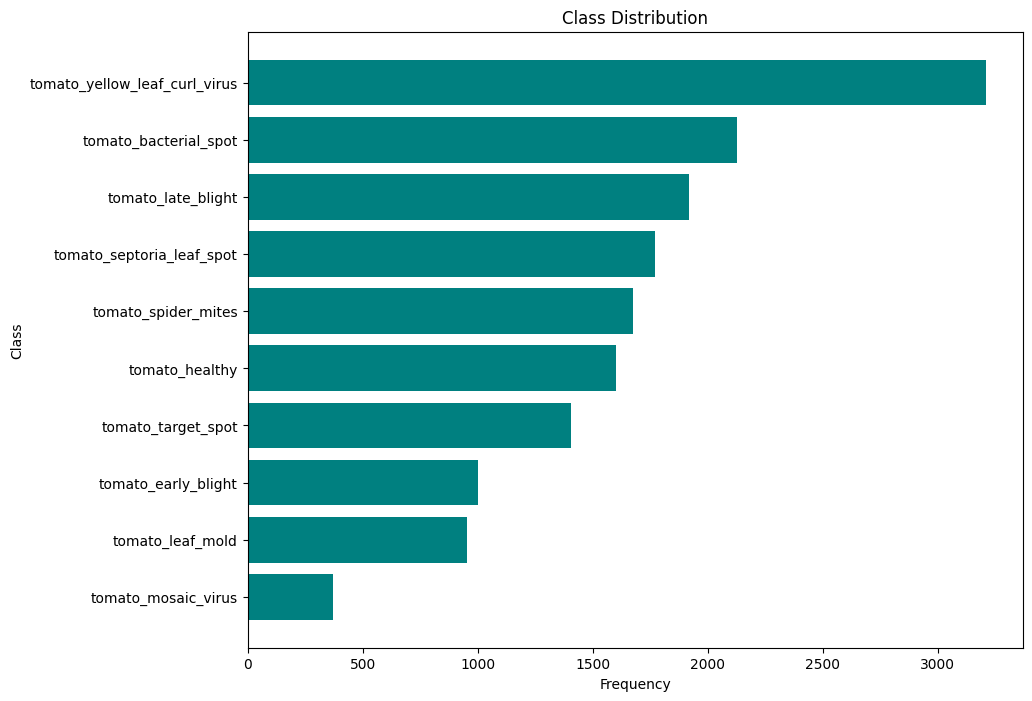

In [ ]:
# Visualize class distribution with a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(sorted_class_distribution.keys()), list(sorted_class_distribution.values()), color='Teal')
plt.title('Class Distribution')
plt.xlabel('Frequency')
plt.ylabel('Class')
plt.show();

In our dataset, there is Class imbalance as observed in the graph above, leaf_curl_virus has the highest number of 3208 while tomato mosaic virus with the least observations of 373 as seen on the graph above.

**Splitting our data set**

In [ ]:
# Creating a split of our data into train, validation and 80% ,10% and 10% Respectivly
def split_data(data, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
  # Calculating the length of our dataset
  data_size = len(data)
  if shuffle:
    data = data.shuffle(shuffle_size) #Shuffling our data
  train_size = int(train_split* len(data))
  val_size = int(val_split*len(data))

  train_set = data.take(train_size)
  val_set = data.skip(train_size).take(val_size)
  test_set = data.skip(train_size).skip(val_size)

  return train_set, val_set, test_set


In [ ]:
# Printing the length of our train, validation and test data
train_set, val_set, test_set = split_data(data)
print(len(train_set))
print(len(val_set))
print(len(test_set))

400
50
51


# Data Modeling

**Caching our data**

In [ ]:


train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Resizing, Rescaling and Augmentation**

In [ ]:
img_size = 256

# Creating an instance to Resize our data
resize_and_rescale = tf.keras.Sequential([
                layers.Resizing(img_size,img_size),
                layers.Rescaling(1.0/255)
])

# Creating a data augmentation instance for our data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)

])

In [ ]:
# Apply data augmentation to the training set only
def augment(image, label):
    image = data_augmentation(image)
    return image, label

train_set = train_set.map(augment)

In [ ]:
# # Define the get_subset function if it's not defined elsewhere
# def get_subset(dataset, fraction):
#   """
#   Returns a subset of the given dataset.

#   Args:
#     dataset: The dataset to extract a subset from.
#     fraction: The fraction of the dataset to return.

#   Returns:
#     A subset of the original dataset.
#   """
#   subset_size = int(len(dataset) * fraction)
#   return dataset.take(subset_size)

# # Data Subset
# train_subset = get_subset(train_set, 1/3)
# val_subset = get_subset(val_set, 1/3)
# test_subset = get_subset(test_set, 1/3)


**Base Model: CNN**

In [ ]:
# prompt: Sequential model

model_c = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(32,256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])


In [ ]:
model_c.build(input_shape = (32,256,256,3))

In [ ]:
model_c.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
#import earlystopping
from tensorflow.keras.callbacks import EarlyStopping
# Defining the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor ='val_accuracy',  # Monitor validation accuracy
    patience = 3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
model_c.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)
history_c = model_c.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=50,
    callbacks = [early_stopping]
)

Epoch 1/50
400/400 [==============================] - 209s 518ms/step - loss: 0.3869 - accuracy: 0.8670 - val_loss: 0.8630 - val_accuracy: 0.7487
Epoch 2/50
400/400 [==============================] - 207s 516ms/step - loss: 0.3602 - accuracy: 0.8750 - val_loss: 0.8228 - val_accuracy: 0.7550
Epoch 3/50
400/400 [==============================] - 204s 510ms/step - loss: 0.3288 - accuracy: 0.8849 - val_loss: 0.3902 - val_accuracy: 0.8625
Epoch 4/50
400/400 [==============================] - 205s 511ms/step - loss: 0.2975 - accuracy: 0.8950 - val_loss: 0.4090 - val_accuracy: 0.8575
Epoch 5/50
400/400 [==============================] - 207s 516ms/step - loss: 0.2907 - accuracy: 0.8973 - val_loss: 0.7033 - val_accuracy: 0.8019
Epoch 6/50
400/400 [==============================] - 206s 514ms/step - loss: 0.2612 - accuracy: 0.9119 - val_loss: 0.2519 - val_accuracy: 0.9087
Epoch 7/50
400/400 [==============================] - 204s 510ms/step - loss: 0.2431 - accuracy: 0.9135 - val_loss: 0.6450 -

In [ ]:
# function to plot training history

def plot_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


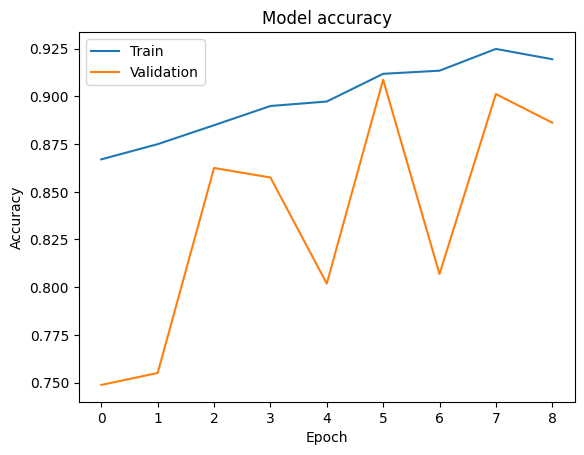

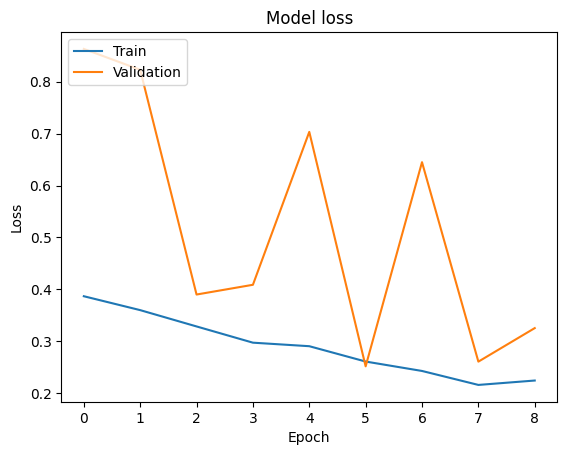

In [ ]:
plot_training_history(history_c)

In [ ]:
test_loss, test_acc = model_c.evaluate(test_set)
print(f'Test accuracy: {test_acc:.2f}')
print(f'Test loss: {test_loss:.2f}')

51/51 [==============================] - 29s 97ms/step - loss: 0.2781 - accuracy: 0.9001
Test accuracy: 0.90
Test loss: 0.28


In [ ]:
# Generate predictions for the test set
predictions = model_c.predict(test_set)

# Assuming test_set has labels and batch size for unpacking
true_labels = []
predicted_labels = []
batch_size = 32  # or any batch size you used in your test set

for images, labels in test_set:
    preds = model_c.predict(images)
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predicted_labels.extend(np.argmax(preds, axis=1))

# Display a sample of predictions
for i in range(10):  # show 10 sample predictions
    print(f"True label: {true_labels[i]}, Predicted label: {predicted_labels[i]}")

1/1 [==============================] - 0s 127ms/step
True label: 6, Predicted label: 5
True label: 2, Predicted label: 2
True label: 2, Predicted label: 2
True label: 4, Predicted label: 4
True label: 5, Predicted label: 5
True label: 5, Predicted label: 5
True label: 9, Predicted label: 9
True label: 5, Predicted label: 5
True label: 6, Predicted label: 5
True label: 6, Predicted label: 6


In [ ]:
# save model in keras

model_c.save('cnnbase_model.keras')


In [ ]:
history_c.history

{'loss': [0.3869115114212036,
  0.36015790700912476,
  0.328750342130661,
  0.2975032329559326,
  0.290713906288147,
  0.26117458939552307,
  0.24305665493011475,
  0.21617333590984344,
  0.22462566196918488],
 'accuracy': [0.867020845413208,
  0.8749902248382568,
  0.88491290807724,
  0.8949918150901794,
  0.8973357081413269,
  0.9118680953979492,
  0.9135088920593262,
  0.9249160289764404,
  0.9195249676704407],
 'val_loss': [0.8630133271217346,
  0.8228091597557068,
  0.39018404483795166,
  0.40895164012908936,
  0.7032987475395203,
  0.25194263458251953,
  0.6449519395828247,
  0.2609870135784149,
  0.32554927468299866],
 'val_accuracy': [0.7487499713897705,
  0.7549999952316284,
  0.862500011920929,
  0.8575000166893005,
  0.8018749952316284,
  0.9087499976158142,
  0.8068749904632568,
  0.9012500047683716,
  0.8862500190734863]}

In [ ]:
#Recording History in json
import json
with open('history_cnn.json','w') as f:
  json.dump(history_c.history,f)

In [ ]:
print(history.history.keys())

Model 2 VGG19

In [ ]:
# Initialize Base
from keras.applications import VGG19
from keras import models # Import the models class
from keras import layers # Import the layers class
# Initialize Base
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))
# Define Model Architecture
model2 = models.Sequential()
model2.add(cnn_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

cnn_base.trainable=False

for layer in model2.layers:
  print(layer.name, layer.trainable)

# check how many trainable weights are in the model
print(len(model2.trainable_weights))

model2.summary()

80134624/80134624 [==============================] - 0s 0us/step
vgg19 False
flatten True
dense True
dense_1 True
dense_2 True
dense_3 True
dense_4 True
10
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
model2.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)#compiling

history2 = model2.fit(
    train_subset,
    batch_size=32,
    validation_data=val_subset,
    verbose=1,
    epochs=50,
    callbacks = [early_stopping]
)

Epoch 1/50
133/133 [==============================] - 250s 1s/step - loss: 1.8626 - accuracy: 0.3973 - val_loss: 1.4862 - val_accuracy: 0.5117
Epoch 2/50
133/133 [==============================] - 140s 1s/step - loss: 1.2154 - accuracy: 0.5891 - val_loss: 1.0382 - val_accuracy: 0.6406
Epoch 3/50
133/133 [==============================] - 139s 1s/step - loss: 1.0416 - accuracy: 0.6431 - val_loss: 0.8896 - val_accuracy: 0.7012
Epoch 4/50
133/133 [==============================] - 139s 1s/step - loss: 0.8374 - accuracy: 0.7126 - val_loss: 0.8546 - val_accuracy: 0.7227
Epoch 5/50
133/133 [==============================] - 139s 1s/step - loss: 0.7897 - accuracy: 0.7380 - val_loss: 0.7394 - val_accuracy: 0.7520
Epoch 6/50
133/133 [==============================] - 139s 1s/step - loss: 0.7034 - accuracy: 0.7594 - val_loss: 0.8415 - val_accuracy: 0.7148
Epoch 7/50
133/133 [==============================] - 139s 1s/step - loss: 0.6301 - accuracy: 0.7850 - val_loss: 0.5812 - val_accuracy: 0.7910

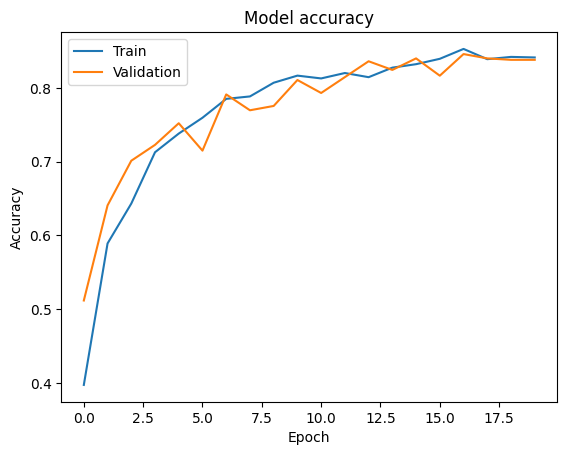

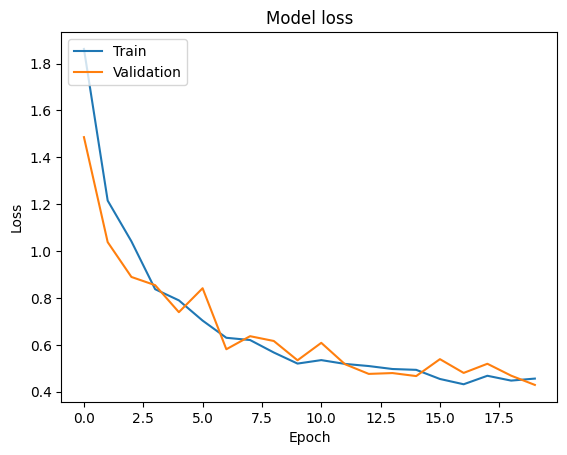

In [ ]:
def plot_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
plot_training_history(history2)

In [ ]:
test_loss, test_acc = model2.evaluate(test_set)
print(f'Test accuracy: {test_acc:.2f}')
print(f'Test loss: {test_loss:.2f}')

51/51 [==============================] - 71s 893ms/step - loss: 0.5084 - accuracy: 0.8419
Test accuracy: 0.84
Test loss: 0.51


In [ ]:
#Recording History in json
import json
with open('history2.json','w') as f:
  json.dump(history2.history,f)

In [ ]:
#saving model3 with keras

model3.save('model3.keras')


In [ ]:
# Initialize Base
from keras.applications import VGG19
from keras import models # Import the models class
from keras import layers # Import the layers class
# Initialize Base
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))
# Define Model Architecture
model3 = models.Sequential()
model3.add(cnn_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(10, activation='softmax'))

cnn_base.trainable=False

for layer in model3.layers:
  print(layer.name, layer.trainable)

# check how many trainable weights are in the model
print(len(model3.trainable_weights))

model3.summary()

vgg19 False
flatten_1 True
dense_5 True
dense_6 True
dense_7 True
dense_8 True
dense_9 True
10
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 64)                2097216   
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                         

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
 # Defining the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor ='val_accuracy',  # Monitor validation accuracy
    patience = 3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
model3.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)#compiling

history3 = model3.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=50,
    callbacks = [early_stopping]
)

Epoch 1/50
400/400 [==============================] - 413s 1s/step - loss: 1.4056 - accuracy: 0.5189 - val_loss: 1.1443 - val_accuracy: 0.6075
Epoch 2/50
400/400 [==============================] - 416s 1s/step - loss: 1.0918 - accuracy: 0.6067 - val_loss: 1.0214 - val_accuracy: 0.6194
Epoch 3/50
400/400 [==============================] - 416s 1s/step - loss: 1.0045 - accuracy: 0.6242 - val_loss: 0.9491 - val_accuracy: 0.6400
Epoch 4/50
400/400 [==============================] - 411s 1s/step - loss: 0.9513 - accuracy: 0.6461 - val_loss: 1.0095 - val_accuracy: 0.6375
Epoch 5/50
400/400 [==============================] - 413s 1s/step - loss: 0.9359 - accuracy: 0.6529 - val_loss: 0.9194 - val_accuracy: 0.6488
Epoch 6/50
400/400 [==============================] - 415s 1s/step - loss: 0.8906 - accuracy: 0.6708 - val_loss: 0.8875 - val_accuracy: 0.6787
Epoch 7/50
400/400 [==============================] - 415s 1s/step - loss: 0.8638 - accuracy: 0.6845 - val_loss: 0.8474 - val_accuracy: 0.6919

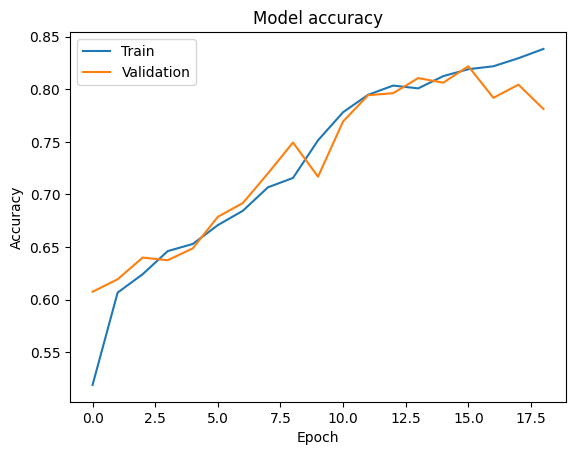

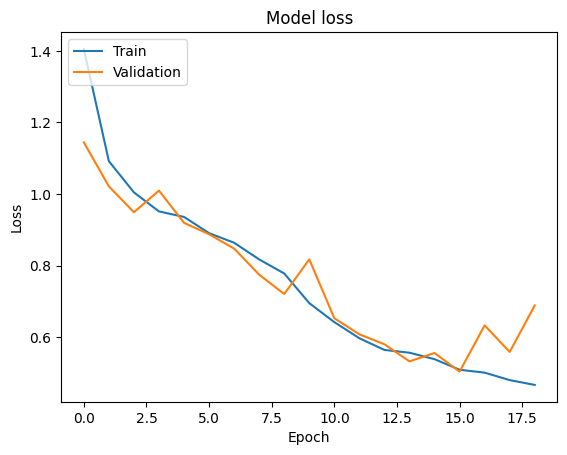

In [ ]:
plot_training_history(history3)

In [ ]:
test_loss, test_acc = model3.evaluate(test_set)
print(f'Test accuracy: {test_acc:.2f}')
print(f'Test loss: {test_loss:.2f}')

51/51 [==============================] - 46s 902ms/step - loss: 0.5127 - accuracy: 0.8180
Test accuracy: 0.82
Test loss: 0.51


In [ ]:
#Recording History in json
import json
with open('history3.json','w') as f:
  json.dump(history3.history,f)

In [ ]:
#

# Load the training history from the JSON file
with open('history3.json', 'r') as f:
    loaded_history3 = json.load(f)

# Print the loaded history
loaded_history3


{'loss': [1.405577540397644,
  1.09177827835083,
  1.0045247077941895,
  0.951328694820404,
  0.9359226226806641,
  0.8906042575836182,
  0.8637927770614624,
  0.8171719908714294,
  0.7778742909431458,
  0.6949834823608398,
  0.6419004201889038,
  0.596825122833252,
  0.5641210079193115,
  0.556391179561615,
  0.5382878184318542,
  0.5087688565254211,
  0.5006904006004333,
  0.47984662652015686,
  0.46635761857032776],
 'accuracy': [0.5189467668533325,
  0.6066880226135254,
  0.6241893768310547,
  0.6461442112922668,
  0.6529416441917419,
  0.6708336472511292,
  0.6845065951347351,
  0.7067739963531494,
  0.7156808972358704,
  0.7514649629592896,
  0.7781857848167419,
  0.7947496175765991,
  0.8035002946853638,
  0.8008438348770142,
  0.8124853372573853,
  0.8190483450889587,
  0.8218610882759094,
  0.8295179605484009,
  0.8383467197418213],
 'val_loss': [1.1442924737930298,
  1.0213873386383057,
  0.9490822553634644,
  1.0095181465148926,
  0.919380247592926,
  0.8875232934951782,
  0

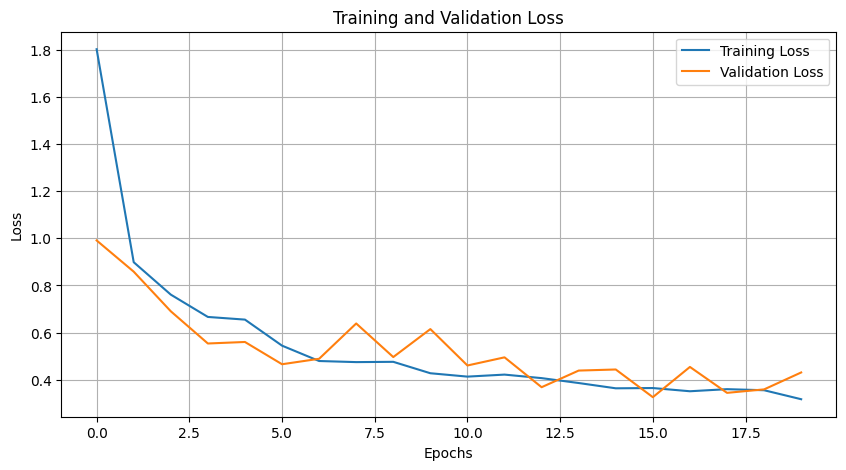

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the loss plot
plt.savefig('loss_plot.png')

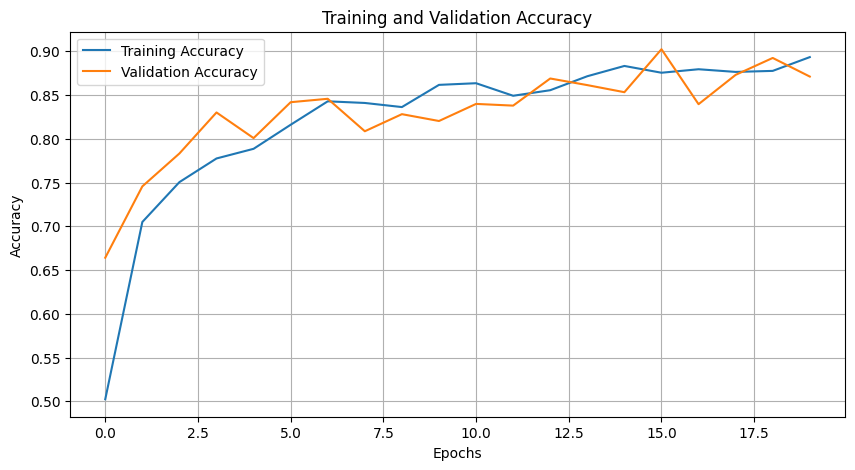

In [ ]:
  # Close the plot to avoid overlap with the next plot

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

Model 3

In [ ]:
# Initialize Base
from keras.applications import VGG19
from keras import models # Import the models class
from keras import layers # Import the layers class
# Initialize Base
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))
# Define Model Architecture
model3 = models.Sequential()
model3.add(cnn_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(10, activation='softmax'))

cnn_base.trainable=False

for layer in model3.layers:
  print(layer.name, layer.trainable)

# check how many trainable weights are in the model
print(len(model3.trainable_weights))

model3.summary()

vgg19 False
flatten_1 True
dense_7 True
dense_8 True
dense_9 True
dense_10 True
dense_11 True
10
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 64)                2097216   
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                       

In [ ]:
model3.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)#compiling

history3 = model3.fit(
    train_subset,
    batch_size=32,
    validation_data=val_subset,
    verbose=1,
    epochs=50,
)

Epoch 1/50
133/133 [==============================] - 137s 1s/step - loss: 1.6972 - accuracy: 0.5424 - val_loss: 0.9017 - val_accuracy: 0.6914
Epoch 2/50
133/133 [==============================] - 137s 1s/step - loss: 0.9226 - accuracy: 0.7002 - val_loss: 0.6269 - val_accuracy: 0.7910
Epoch 3/50
133/133 [==============================] - 136s 1s/step - loss: 0.7222 - accuracy: 0.7662 - val_loss: 0.6057 - val_accuracy: 0.8184
Epoch 4/50
133/133 [==============================] - 134s 1s/step - loss: 0.5973 - accuracy: 0.8031 - val_loss: 0.4945 - val_accuracy: 0.8184
Epoch 5/50
133/133 [==============================] - 135s 1s/step - loss: 0.5394 - accuracy: 0.8217 - val_loss: 0.7388 - val_accuracy: 0.8008
Epoch 6/50
133/133 [==============================] - 134s 1s/step - loss: 0.5114 - accuracy: 0.8275 - val_loss: 0.4955 - val_accuracy: 0.8379
Epoch 7/50
133/133 [==============================] - 135s 1s/step - loss: 0.4780 - accuracy: 0.8402 - val_loss: 0.3945 - val_accuracy: 0.8750

In [ ]:
plot_training_history(history3)

In [ ]:
test_loss, test_acc = model3.evaluate(test_set)
print(f'Test accuracy: {test_acc:.2f}')
print(f'Test loss: {test_loss:.2f}')

51/51 [==============================] - 68s 861ms/step - loss: 0.4350 - accuracy: 0.8640
Test accuracy: 0.86
Test loss: 0.44


In [ ]:
#inception v3 model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
predictions = Dense(10, activation='softmax')(x)  # Add a softmax layer for classification

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Defining the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor ='val_accuracy',  # Monitor validation accuracy
    patience = 3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Train the model
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=50,
    callbacks = [early_stopping])



Epoch 1/50
400/400 [==============================] - 202s 430ms/step - loss: 4.8041 - accuracy: 0.4059 - val_loss: 1.9176 - val_accuracy: 0.4538
Epoch 2/50
400/400 [==============================] - 155s 386ms/step - loss: 1.4594 - accuracy: 0.4950 - val_loss: 1.6312 - val_accuracy: 0.4263
Epoch 3/50
400/400 [==============================] - 150s 375ms/step - loss: 1.3576 - accuracy: 0.5245 - val_loss: 1.4817 - val_accuracy: 0.4762
Epoch 4/50
400/400 [==============================] - 152s 379ms/step - loss: 1.2822 - accuracy: 0.5478 - val_loss: 1.5507 - val_accuracy: 0.4731
Epoch 5/50
400/400 [==============================] - 149s 373ms/step - loss: 1.2643 - accuracy: 0.5543 - val_loss: 1.4898 - val_accuracy: 0.4863
Epoch 6/50
400/400 [==============================] - 152s 379ms/step - loss: 1.2329 - accuracy: 0.5685 - val_loss: 1.4316 - val_accuracy: 0.5056
Epoch 7/50
400/400 [==============================] - 156s 390ms/step - loss: 1.2315 - accuracy: 0.5636 - val_loss: 1.6323 -

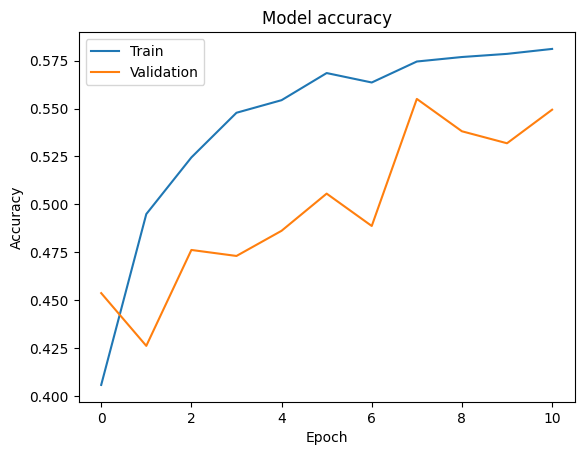

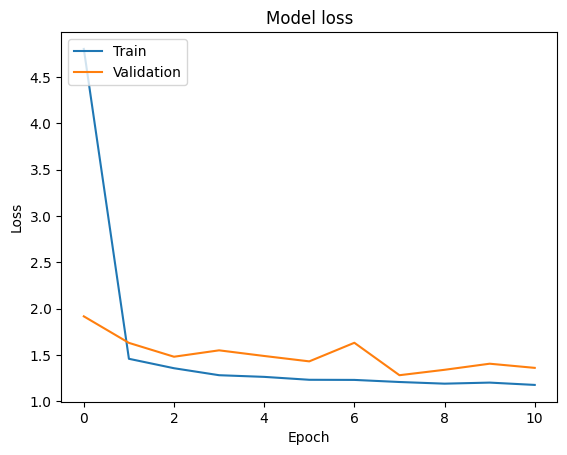

In [ ]:
def plot_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
plot_training_history(history)

In [ ]:
import json
model.save('inceptionv3.keras')
with open('inceptionv3.json', 'w') as f:
    json.dump(history.history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)
